# Import

In [1]:
from datasets import load_dataset
from matplotlib import pyplot as plt
import torch
import transformers
from transformers import (
    AutoModelForCausalLM, 
    BitsAndBytesConfig, 
    AutoTokenizer,
    TrainingArguments
)
from peft import (
    LoraConfig, 
    get_peft_model,
    TaskType
    )
from trl import SFTTrainer


/home/nguyen/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-30 10:51:56.695455: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 10:51:56.980802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 10:51:57.551936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Te

# Dataset

In [2]:
dataset_name = "databricks/databricks-dolly-15k"
dolly_15k = load_dataset(dataset_name)
print(dolly_15k)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})


# EDA on dataset

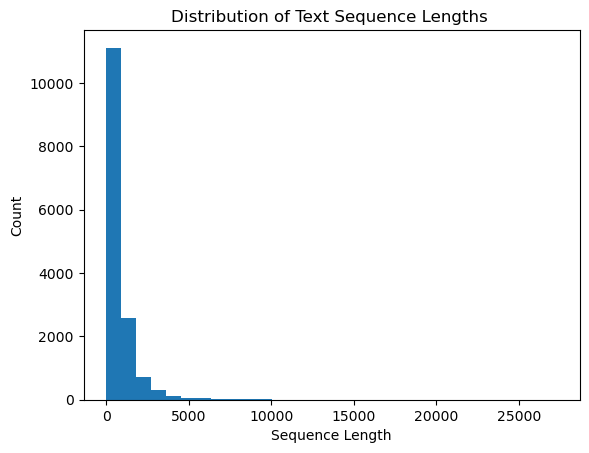

[9, 10, 25, 40, 59, 73, 76, 96, 145, 175]


In [3]:
def plot_sequence_len(ds, title = ''):
    too_long_idx = []
    seq_len = []

    for idx, example in enumerate(ds):
        length = len(example['instruction']) \
            + len(example['context']) \
            + len(example['response'])
        seq_len.append(length)

        if seq_len[idx]  > 2200:
            too_long_idx.append(idx)
    
    plt.hist(seq_len, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths ' + title)
    plt.show()

    return too_long_idx

too_long_idx = plot_sequence_len(dolly_15k['train'])

#filter out too long idx

print(too_long_idx[:10])

In [4]:
total_len = len(dolly_15k['train'])
print('total len = ', total_len)

total len =  15011


In [5]:
dolly_15k_reduced = dolly_15k['train'].select(
        i for i in range(total_len) 
        if i not in set(too_long_idx)
    )

#split train and test
dolly_15k_reduced = dolly_15k_reduced.train_test_split(test_size = 0.1)
print(dolly_15k_reduced)

Parameter 'indices'=<generator object <genexpr> at 0x738c2d91a0a0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})


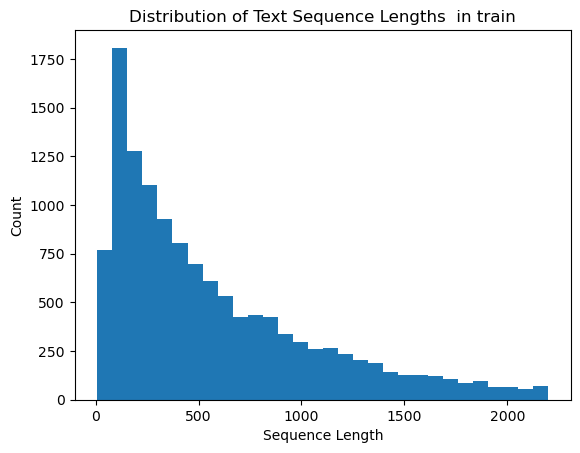

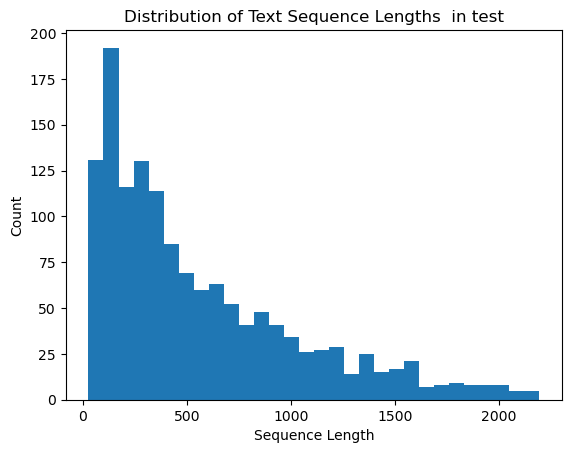

[]

In [6]:
plot_sequence_len(dolly_15k_reduced['train'], " in train")
plot_sequence_len(dolly_15k_reduced['test'], " in test")

In [7]:
a = ( "something" 
    "another"
    "weird"
)

print(a)
print(type(a))

somethinganotherweird
<class 'str'>


In [8]:
def format_func(example):
    #PEFT format
    if example.get("context", "") != "":
        #if this sample has context, use context as input, 
        input_prompt = (
            f"Below is an instruction that describes a task, paired with an input that provides further context. " 
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n"
            f"{example['instruction']}\n\n"
            f"### Input: \n"
            f"{example['context']}\n\n"
            f"### Response: \n"
            f"{example['response']}"
        )
    else:
        #default prompt
        input_prompt = (f"Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n"
            f"{example['instruction']}\n\n"
            f"### Response:\n"
            f"{example['response']}"
        )
    return {'text' : input_prompt}


formatted_dataset = dolly_15k_reduced.map(format_func)

#check after formatting
for example in formatted_dataset['train']:
    print(example)
    break

print(formatted_dataset)


Map: 100%|██████████| 1408/1408 [00:00<00:00, 24831.62 examples/s]

{'instruction': "What's the capital city of Czechoslovakia?", 'context': '', 'response': 'Czechoslovakia is no longer a sovereign state. It ceased to exist following the deposition of its communist leaders in a process known as the Velvet Revolution. Following the fall of that regime it split peacefully at the end of 1992 into the Czech Republic and Slovakia. The capital cities of those two nations are Prague and Bratislava respectively. While Czechoslovakia was in existence Prague was its capital.', 'category': 'general_qa', 'text': "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat's the capital city of Czechoslovakia?\n\n### Response:\nCzechoslovakia is no longer a sovereign state. It ceased to exist following the deposition of its communist leaders in a process known as the Velvet Revolution. Following the fall of that regime it split peacefully at the end of 1992 into the Czech Republic and Slovakia.

# Setup QLoRA (read the paper) and Quantization config

In [9]:
peft_config = LoraConfig(
    r = 16, 
    lora_alpha=32,
    lora_dropout=0.05,
    bias = 'none',
    task_type=TaskType.CAUSAL_LM, 
)

# BnB config

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "meta-llama/Meta-Llama-3-8B"

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config = bnb_config,
    device_map = "auto",
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


In [11]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

# Tokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [15]:
sft = SFTTrainer(
    base_model,
    train_dataset = formatted_dataset['train'],
    eval_dataset = formatted_dataset['test'],
    args = TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps = 4,
        learning_rate = 2e-4,
        max_steps = 5000,
        output_dir = './sft_llama_dolly15k',
        optim = 'paged_adamw_8bit',
        fp16 = True
    ),
    tokenizer=tokenizer,
    peft_config=peft_config,
    dataset_text_field='text',
    max_seq_length = 512
)

/home/nguyen/anaconda3/envs/torch/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/nguyen/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/home/nguyen/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/home/nguyen/anaconda3/envs/torch/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:269: UserWarning: You 

In [16]:
sft.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1002.00 MiB. GPU 